# Training Data Generation for Fast-SCNN Segmentation

This notebook generates synthetic training data for cone and ball segmentation with depth.

**Object Classes:**
- Cones: red, orange, purple, green, yellow, blue
- Balls: red, yellow, blue, green

**Camera:** RealSense D455 (640x480)

**Dependencies:**
```
pip install drake pytransform3d manipulation opencv-python
```


In [1]:
import argparse
import json
import multiprocessing
import os
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pytransform3d.rotations as pyt_r
from PIL import Image
import cv2
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    Parser,
    RandomGenerator,
    RigidTransform,
    Role,
    RollPitchYaw,
    Simulator,
    UniformlyRandomRotationMatrix,
)

from manipulation.scenarios import AddRgbdSensor, ycb
from manipulation.utils import ConfigureParser, colorize_labels

import manipulation
from manipulation.meshcat_utils import MeshcatSliders, StopButton
from manipulation.scenarios import AddShape
from manipulation.utils import RenderDiagram, ConfigureParser

from pydrake.all import (
    DiagramBuilder,
    Simulator,
    StartMeshcat,
    RotationMatrix,
    RollPitchYaw,
    MultibodyPlant,
    Demultiplexer,
    DiscreteContactApproximation,
    ConstantVectorSource,
    Parser,
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    DiagramBuilder,
    JointSliders,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Multiplexer,
    Parser,
    PrismaticJoint,
    SceneGraph,
    SpatialInertia,
    Sphere,
    UnitInertia,
    MeshcatVisualizerParams,
    LoadModelDirectivesFromString,
    RigidTransform,
    ProcessModelDirectives,
    AddDefaultVisualization,
    SimIiwaDriver,
    IiwaControlMode,
    LeafSystem,
    PortSwitch,
    SchunkWsgPositionController
)

from pydrake.geometry import (
    RenderEngineVtkParams,
    MakeRenderEngineVtk,
    LightParameter,
    Rgba,
)
from pydrake.systems.sensors import CameraConfig, ApplyCameraConfig
from pydrake.geometry import GeometrySet, Role


## Configuration and Constants


In [2]:
## DATASET CONFIGURATION
NUM_IMAGES = 10000  # Number of training images to generate
OUTPUT_DIR = "training_images"  # Output directory

## CAMERA CONFIGURATION (RealSense D455)
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480
CAMERA_FOV = 87.0  # Field of view in degrees (horizontal for D455)

# Spawn locations
FOCUS_RANGE = 1.0  # meters, centroid objects spawn at
SPAWN_RANGE = 0.2  # meters, range around focus to spawn objects

# Camera
CAM_SPAWN_RANGE = 0.2  # meters, centered at origin
CAM_HEIGHT_RANGE = (0.6, 3)  # meters from ground
CAM_ORIENTATION_STD = 0.2  # radians, normal distribution std on roll pitch and yaw

# Lights
LIGHT_SPAWN_RANGE = 2.0  # meters, centered at origin
LIGHT_HEIGHT_RANGE = (0.5, 4)  # meters, min and max
LIGHT_RANGE = (2, 6)  # min and max number of scene lights

# Clutter
CLUTTER_RANGE = (0, 5)  # number of clutter, min and max

# Objects of Interest
OOI_RANGE = (3, 8)  # number of OOIs, min and max
OOI_SIZE_CONE_RANGE = (0.05, 0.1)  # meters, cone sizes
OOI_SIZE_BALL_RANGE = (0.03, 0.08)  # meters, ball radius

# Object color definitions (RGB)
CONE_COLORS = {
    'red': (1.0, 0.0, 0.0),
    'orange': (1.0, 0.5, 0.0),
    'purple': (0.5, 0.0, 0.5),
    'green': (0.0, 1.0, 0.0),
    'yellow': (1.0, 1.0, 0.0),
    'blue': (0.0, 0.0, 1.0),
}

BALL_COLORS = {
    'red': (1.0, 0.0, 0.0),
    'yellow': (1.0, 1.0, 0.0),
    'blue': (0.0, 0.0, 1.0),
    'green': (0.0, 1.0, 0.0),
}

COLOR_NOISE_STD = 0.05  # Small noise applied to colors for variety

# Label mapping for segmentation
# 0 = background
# 1-6 = cones (red, orange, purple, green, yellow, blue)
# 7-10 = balls (red, yellow, blue, green)
CONE_LABELS = {name: idx+1 for idx, name in enumerate(['red', 'orange', 'purple', 'green', 'yellow', 'blue'])}
BALL_LABELS = {name: idx+7 for idx, name in enumerate(['red', 'yellow', 'blue', 'green'])}

print("Cone labels:", CONE_LABELS)
print("Ball labels:", BALL_LABELS)


Cone labels: {'red': 1, 'orange': 2, 'purple': 3, 'green': 4, 'yellow': 5, 'blue': 6}
Ball labels: {'red': 7, 'yellow': 8, 'blue': 9, 'green': 10}


## RealSense D455 Noise Models

Based on RealSense D455 characteristics:
- RGB sensor noise
- Depth sensor noise (structured light patterns)


In [3]:
def add_realsense_rgb_noise(image, rng):
    """
    Add realistic RGB sensor noise characteristic of RealSense D455.
    Includes:
    - Gaussian sensor noise
    - Shot noise (signal-dependent)
    - Slight motion blur
    """
    image = image.astype(np.float32)
    
    # Gaussian sensor noise (increases in low light)
    noise_level = rng.uniform(2, 8)
    gaussian_noise = rng.normal(0, noise_level, image.shape)
    image = image + gaussian_noise
    
    # Shot noise (signal-dependent, Poisson-like)
    shot_noise = rng.normal(0, 1, image.shape) * np.sqrt(np.maximum(image, 0)) * 0.3
    image = image + shot_noise
    
    # Slight random motion blur (simulates camera/object motion)
    if rng.random() < 0.3:  # 30% chance of motion blur
        kernel_size = rng.choice([3, 5])
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    # Clip to valid range
    image = np.clip(image, 0, 255).astype(np.uint8)
    
    return image


def add_realsense_depth_noise(depth_image, rng):
    """
    Add realistic depth sensor noise characteristic of RealSense D455 (structured light).
    Includes:
    - Distance-dependent noise (increases with distance)
    - Invalid/missing depth values (holes)
    - Edge artifacts
    - Quantization noise
    """
    depth = depth_image.copy()
    
    # Distance-dependent Gaussian noise
    # RealSense depth error increases quadratically with distance
    # At 1m: ~2mm, at 2m: ~8mm, at 3m: ~18mm
    noise_scale = 0.002 * (depth ** 2) + 0.001 * depth
    depth_noise = rng.normal(0, 1, depth.shape) * noise_scale
    depth = depth + depth_noise
    
    # Random dropout/invalid pixels (common in structured light sensors)
    # More likely at edges and far distances
    dropout_prob = np.minimum(0.01 + 0.05 * (depth / 4.0), 0.15)
    dropout_mask = rng.random(depth.shape) < dropout_prob
    depth[dropout_mask] = 0  # Invalid depth
    
    # Edge artifacts (depth discontinuities often have errors)
    # Detect edges and add noise
    if depth.max() > 0:
        depth_normalized = (depth / depth.max() * 255).astype(np.uint8)
        edges = cv2.Canny(depth_normalized, 50, 150)
        edge_mask = edges > 0
        # Dilate edges slightly
        kernel = np.ones((3, 3), np.uint8)
        edge_mask = cv2.dilate(edge_mask.astype(np.uint8), kernel, iterations=1) > 0
        # Add extra noise at edges
        edge_noise = rng.normal(0, 0.01, depth.shape)
        depth[edge_mask] += edge_noise[edge_mask]
    
    # Quantization noise (depth is digitized)
    # D455 has sub-millimeter resolution, but we add slight quantization
    quantization = 0.001  # 1mm quantization
    depth = np.round(depth / quantization) * quantization
    
    # Ensure no negative depths
    depth = np.maximum(depth, 0)
    
    return depth


## Scene Setup


In [4]:
# Setup output directory
if os.path.exists(OUTPUT_DIR):
    response = input(f"Directory '{OUTPUT_DIR}' exists. Delete and recreate? (y/n): ")
    if response.lower() == 'y':
        pass
        # shutil.rmtree(OUTPUT_DIR)
    else:
        print("Using existing directory. Files may be overwritten.")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "rgb"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "depth"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "masks"), exist_ok=True)

# Save label mapping
label_info = {
    "background": 0,
    "cones": CONE_LABELS,
    "balls": BALL_LABELS,
}
with open(os.path.join(OUTPUT_DIR, "label_mapping.json"), "w") as f:
    json.dump(label_info, f, indent=2)

print(f"Output directory: {OUTPUT_DIR}")
print(f"Label mapping saved to {OUTPUT_DIR}/label_mapping.json")


Using existing directory. Files may be overwritten.
Output directory: training_images
Label mapping saved to training_images/label_mapping.json


In [5]:
world_directives = f"""
directives:
- add_model:
    name: table
    file: file://{os.getcwd()}/models/ground.sdf
- add_weld:
    parent: world
    child: table::base
"""


In [6]:
clutter_directive = """
directives:
- add_model:
    name: clutter{num}
    file: package://manipulation/hydro/{name}
"""


In [7]:
# Object templates
sphere_xml = """
<mujoco model="ball_{color}_{num}">
  <worldbody>
    <body name="ball_{color}_{num}" pos="0 0 1" euler="30 0 45">
      <geom name="ball_{color}_{num}" type="sphere" size="{size}" rgba="{r} {g} {b} 1"/>
      <joint type="free" name="free"/>
    </body>
  </worldbody>
</mujoco>
"""

class cone_urdf:
    def format(self, size, r, g, b, color, num):
        size_scale = 6 + (size - (OOI_SIZE_CONE_RANGE[0] + OOI_SIZE_CONE_RANGE[1]) / 2)
        
        return f"""<?xml version='1.0'?>
<sdf version='1.8'>
  <model name='cone_{color}_{num}'>
    <link name='link'>
      <visual name='visual'>
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <mesh>
            <uri>file://{os.getcwd()}/models/traffic_cone.obj</uri>
            <scale>{size_scale} {size_scale} {size_scale}</scale>
          </mesh>
        </geometry>
        <material>
          <ambient>{r} {g} {b} 1</ambient>
          <diffuse>{r} {g} {b} 1</diffuse>
        </material>
      </visual>
      <collision name='collision'>
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <mesh>
            <uri>file://{os.getcwd()}/models/traffic_cone.obj</uri>
            <scale>{size_scale} {size_scale} {size_scale}</scale>
          </mesh>
        </geometry>
      </collision>
    </link>
  </model>
</sdf>
"""


## Helper Functions


In [8]:
rng = np.random.default_rng()  # this is for python
generator = RandomGenerator(rng.integers(1000))  # for c++


In [9]:
def lookat(cam_position: np.ndarray, target_position: np.ndarray) -> np.ndarray:
    """Calculate camera rotation matrix to look at target."""
    forward = target_position - cam_position
    forward = forward / np.linalg.norm(forward)
    
    right = np.cross(forward, np.array([0, 0, 1]))
    right = right / np.linalg.norm(right)
    
    up = np.cross(forward, right)
    up = up / np.linalg.norm(up)
    
    return np.column_stack((right, up, forward))


In [10]:
def make_random_light():
    """Create a random point light for the scene."""
    intensity = float(10 ** rng.uniform(-1.0, 0.8))
    color = Rgba(
        rng.uniform(0.7, 1.0),
        rng.uniform(0.65, 1.0),
        rng.uniform(0.6, 1.0),
        1.0
    )
    return LightParameter(
        type="point",
        position=[
            rng.uniform(-LIGHT_SPAWN_RANGE, LIGHT_SPAWN_RANGE),
            rng.uniform(-LIGHT_SPAWN_RANGE, LIGHT_SPAWN_RANGE),
            rng.uniform(LIGHT_HEIGHT_RANGE[0], LIGHT_HEIGHT_RANGE[1])],
        intensity=intensity,
        color=color,
        frame="world",
    )

def clip_color(c):
    """Clip color value to [0, 1]."""
    return max(min(c, 1), 0)


In [11]:
def get_render_labels(inspector, model_ids):
    """Get all render labels for given model IDs."""
    all_geom_ids = inspector.GetAllGeometryIds(Role.kPerception)
    render_labels = []
    for geom_id in all_geom_ids:
        frame_id = inspector.GetFrameId(geom_id)
        frame_group = inspector.GetFrameGroup(frame_id)
        if frame_group in model_ids:
            props = inspector.GetProperties(geom_id, Role.kPerception)
            if props is None:
                continue
            if props.HasProperty("label", "id"):
                rl = props.GetProperty("label", "id")
                render_labels.append(int(rl))
    return render_labels


## Main Image Generation Function


In [12]:
def image_scene():
    """Generate a single synthetic scene with RGB, depth, and segmentation mask."""
    # Pick an (x,y) location to spawn everything around
    focus = (
        rng.uniform(-FOCUS_RANGE, FOCUS_RANGE),
        rng.uniform(-FOCUS_RANGE, FOCUS_RANGE),
    )
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0005)
    
    renderer_name = "vtk_renderer_egl"
    vtk_params = RenderEngineVtkParams()
    vtk_params.cast_shadows = True
    vtk_params.force_to_pbr = False
    
    # Random lights
    vtk_params.lights = [make_random_light() for _ in range(int(rng.integers(LIGHT_RANGE[0], LIGHT_RANGE[1])))]
    
    renderer = MakeRenderEngineVtk(vtk_params)
    scene_graph.AddRenderer(renderer_name, renderer)
    
    parser = Parser(plant)
    ConfigureParser(parser)
    
    directive = LoadModelDirectivesFromString(world_directives)
    ProcessModelDirectives(directive, parser)
    
    # Spawn clutter in the environment
    num_clutter = rng.integers(CLUTTER_RANGE[0], CLUTTER_RANGE[1])
    for clutter_num in range(num_clutter):
        clutter_name = ycb[rng.integers(len(ycb))]
        directive = clutter_directive.format(num=clutter_num, name=clutter_name)
        parser.AddModelsFromString(directive, ".dmd.yaml")[0]
    
    # Track model IDs for each object type (for label assignment)
    object_model_ids = {}  # {label_id: [model_ids]}
    
    # Spawn cones of different colors
    cone_template = cone_urdf()
    cone_colors_list = list(CONE_COLORS.keys())
    num_cones = rng.integers(1, max(2, OOI_RANGE[1] // 2 + 1))
    
    for cone_num in range(num_cones):
        color_name = rng.choice(cone_colors_list)
        base_color = CONE_COLORS[color_name]
        size = rng.uniform(OOI_SIZE_CONE_RANGE[0], OOI_SIZE_CONE_RANGE[1])
        
        # Add color variation
        color = (
            clip_color(base_color[0] + rng.normal(0, COLOR_NOISE_STD)),
            clip_color(base_color[1] + rng.normal(0, COLOR_NOISE_STD)),
            clip_color(base_color[2] + rng.normal(0, COLOR_NOISE_STD)),
        )
        
        directive = cone_template.format(
            num=cone_num,
            size=size,
            r=color[0],
            g=color[1],
            b=color[2],
            color=color_name,
        )
        
        model_id = parser.AddModelsFromString(directive, ".sdf")[0]
        label_id = CONE_LABELS[color_name]
        
        if label_id not in object_model_ids:
            object_model_ids[label_id] = []
        object_model_ids[label_id].append(int(model_id))
    
    # Spawn balls of different colors
    ball_colors_list = list(BALL_COLORS.keys())
    num_balls = rng.integers(1, max(2, OOI_RANGE[1] // 2 + 1))
    
    for ball_num in range(num_balls):
        color_name = rng.choice(ball_colors_list)
        base_color = BALL_COLORS[color_name]
        size = rng.uniform(OOI_SIZE_BALL_RANGE[0], OOI_SIZE_BALL_RANGE[1])
        
        # Add color variation
        color = (
            clip_color(base_color[0] + rng.normal(0, COLOR_NOISE_STD)),
            clip_color(base_color[1] + rng.normal(0, COLOR_NOISE_STD)),
            clip_color(base_color[2] + rng.normal(0, COLOR_NOISE_STD)),
        )
        
        directive = sphere_xml.format(
            num=ball_num,
            size=size,
            r=color[0],
            g=color[1],
            b=color[2],
            color=color_name,
        )
        
        model_id = parser.AddModelsFromString(directive, ".xml")[0]
        label_id = BALL_LABELS[color_name]
        
        if label_id not in object_model_ids:
            object_model_ids[label_id] = []
        object_model_ids[label_id].append(int(model_id))
    
    plant.Finalize()
    
    # Camera is looking at the focus, with orientation noise
    cam_position = np.array(
        [
            rng.uniform(-CAM_SPAWN_RANGE, CAM_SPAWN_RANGE),
            rng.uniform(-CAM_SPAWN_RANGE, CAM_SPAWN_RANGE),
            rng.uniform(CAM_HEIGHT_RANGE[0], CAM_HEIGHT_RANGE[1]),
        ]
    )
    focus_position = np.array([*focus, 0.0])
    
    R_lookat = lookat(cam_position, focus_position)
    rpy_lookat = pyt_r.euler_from_matrix(
        R_lookat, i=0, j=1, k=2, extrinsic=True
    ) + rng.normal(loc=0, scale=CAM_ORIENTATION_STD, size=3)
    
    # Spawn camera with RealSense D455 specs
    camera = AddRgbdSensor(
        builder,
        scene_graph,
        RigidTransform(RollPitchYaw(rpy_lookat), cam_position),
        renderer="vtk_renderer_egl",
    )
    camera.set_name("rgbd_sensor")
    builder.ExportOutput(camera.color_image_output_port(), "color_image")
    builder.ExportOutput(camera.label_image_output_port(), "label_image")
    builder.ExportOutput(camera.depth_image_32F_output_port(), "depth_image")
    
    diagram = builder.Build()
    
    # Spawn all objects and let them settle
    max_attempts = 10
    for attempt in range(max_attempts):
        try:
            simulator = Simulator(diagram)
            context = simulator.get_mutable_context()
            plant_context = plant.GetMyContextFromRoot(context)
            
            z = 0.1
            for body_index in plant.GetFloatingBaseBodies():
                tf = RigidTransform(
                    UniformlyRandomRotationMatrix(generator),
                    [
                        rng.uniform(focus[0] - SPAWN_RANGE, focus[0] + SPAWN_RANGE),
                        rng.uniform(focus[1] - SPAWN_RANGE, focus[1] + SPAWN_RANGE),
                        z,
                    ],
                )
                plant.SetFreeBodyPose(plant_context, plant.get_body(body_index), tf)
                z += 0.1
            
            simulator.AdvanceTo(1.0)
            simulator.AdvanceTo(2.0)
            break
        except RuntimeError:
            if attempt == max_attempts - 1:
                raise
            continue
    
    # Grab the images from the camera
    color_image = diagram.GetOutputPort("color_image").Eval(context).data
    label_image = diagram.GetOutputPort("label_image").Eval(context).data
    depth_image = diagram.GetOutputPort("depth_image").Eval(context).data
    
    inspector = scene_graph.model_inspector()
    
    # Map render labels to semantic labels
    output_label_image = np.zeros_like(label_image, dtype=np.uint8)
    for semantic_label, model_ids in object_model_ids.items():
        render_labels = get_render_labels(inspector, model_ids)
        mask = np.isin(label_image, render_labels)
        output_label_image[mask] = semantic_label
    
    return color_image, depth_image, output_label_image


## Generate Single Test Image


Generating test image...


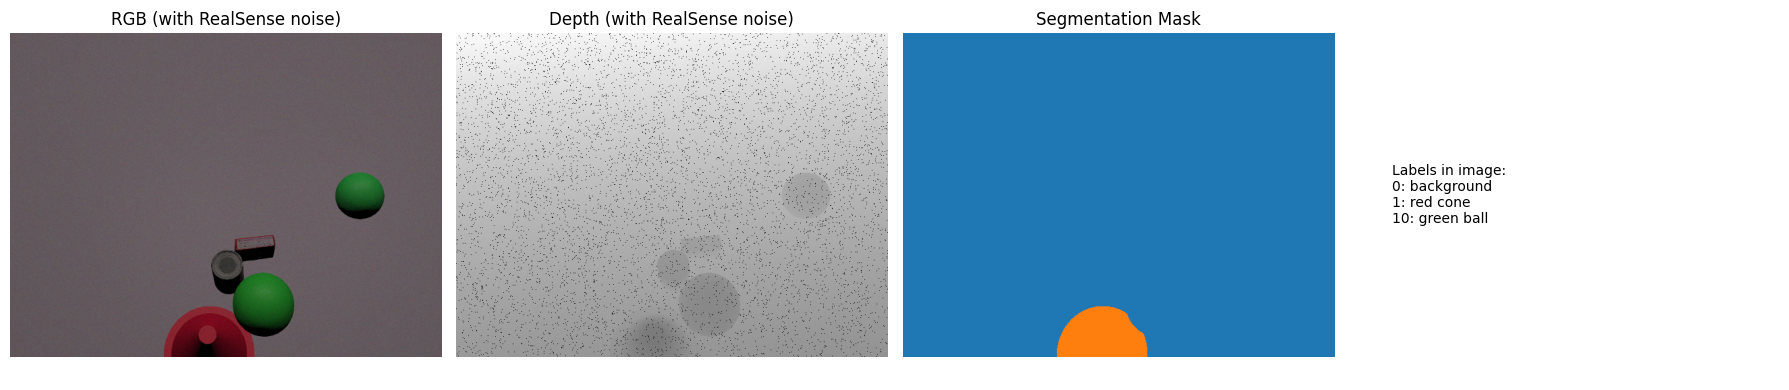

Image shape: RGB=(480, 640, 3), Depth=(480, 640), Mask=(480, 640)
Depth range: 0.000 to 1.372 meters
Unique labels in scene: [ 0  1 10]


: 

In [ ]:
# Generate and visualize a single test image
print("Generating test image...")
color_image, depth_image, label_image = image_scene()

# Squeeze extra dimensions if present (Drake returns shape (H, W, 1) or (H, W, C))
if color_image.ndim == 3 and color_image.shape[2] == 4:
    color_image = color_image[:, :, :3]  # Remove alpha channel if present
if depth_image.ndim == 3:
    depth_image = depth_image.squeeze()  # (H, W, 1) -> (H, W)
if label_image.ndim == 3:
    label_image = label_image.squeeze()  # (H, W, 1) -> (H, W)

# Add RealSense noise
color_image_noisy = add_realsense_rgb_noise(color_image, rng)
depth_image_noisy = add_realsense_depth_noise(depth_image, rng)

# Visualize
plt.figure(figsize=(18, 4))
plt.subplot(141)
plt.imshow(color_image_noisy)
plt.title("RGB (with RealSense noise)")
plt.axis("off")

plt.subplot(142)
plt.imshow(depth_image_noisy, cmap='gray')
plt.title("Depth (with RealSense noise)")
plt.axis("off")

plt.subplot(143)
colorized_mask = colorize_labels(label_image)
# Ensure proper format for display
if colorized_mask.dtype != np.uint8:
    colorized_mask = (colorized_mask * 255).astype(np.uint8) if colorized_mask.max() <= 1.0 else colorized_mask.astype(np.uint8)
plt.imshow(colorized_mask)
plt.title("Segmentation Mask")
plt.axis("off")

# Show unique labels
unique_labels = np.unique(label_image)
plt.subplot(144)
label_names = []
for lbl in unique_labels:
    if lbl == 0:
        label_names.append(f"{lbl}: background")
    else:
        # Find label name
        for name, l in CONE_LABELS.items():
            if l == lbl:
                label_names.append(f"{lbl}: {name} cone")
                break
        else:
            for name, l in BALL_LABELS.items():
                if l == lbl:
                    label_names.append(f"{lbl}: {name} ball")
                    break

plt.text(0.1, 0.5, "Labels in image:\n" + "\n".join(label_names), 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Image shape: RGB={color_image_noisy.shape}, Depth={depth_image_noisy.shape}, Mask={label_image.shape}")
print(f"Depth range: {depth_image_noisy.min():.3f} to {depth_image_noisy.max():.3f} meters")
print(f"Unique labels in scene: {unique_labels}")


## Generate Training Dataset

This will generate `NUM_IMAGES` training samples and save them to disk.


In [ ]:
from tqdm import tqdm
import traceback
import gc 
from IPython.display import clear_output

print(f"Generating {NUM_IMAGES} training images...")
print(f"Output directory: {OUTPUT_DIR}")

successful = 0
failed = 0
START_FROM = 1250
stats = {"labels_per_image": []}

for i in tqdm(range(NUM_IMAGES)):
    if i % 25 == 0:
        clear_output(wait=True)  # Clear old output
        gc.collect()

    try:
        # Generate scene
        color_image, depth_image, label_image = image_scene()
        
        # Squeeze extra dimensions if present (Drake returns shape (H, W, 1) or (H, W, C))
        if color_image.ndim == 3 and color_image.shape[2] == 4:
            color_image = color_image[:, :, :3]  # Remove alpha channel if present
        if depth_image.ndim == 3:
            depth_image = depth_image.squeeze()  # (H, W, 1) -> (H, W)
        if label_image.ndim == 3:
            label_image = label_image.squeeze()  # (H, W, 1) -> (H, W)
        
        # Add RealSense noise
        color_image_noisy = add_realsense_rgb_noise(color_image, rng)
        depth_image_noisy = add_realsense_depth_noise(depth_image, rng)
        
        # Save images
        filename = f"{START_FROM + i:06d}"
        
        # Save RGB
        Image.fromarray(color_image_noisy).save(
            os.path.join(OUTPUT_DIR, "rgb", f"{filename}.png")
        )
        
        # Save depth as 16-bit PNG (millimeters)
        depth_mm = (depth_image_noisy * 1000).astype(np.uint16)
        Image.fromarray(depth_mm).save(
            os.path.join(OUTPUT_DIR, "depth", f"{filename}.png")
        )
        
        # Save mask as numpy array (more precise than PNG for labels)
        np.save(
            os.path.join(OUTPUT_DIR, "masks", f"{filename}.npy"),
            label_image
        )
        
        # Also save a colorized version for visualization
        colorized = colorize_labels(label_image)
        # Ensure proper format for PIL (uint8, shape (H, W, 3))
        if colorized.dtype != np.uint8:
            colorized = (colorized * 255).astype(np.uint8) if colorized.max() <= 1.0 else colorized.astype(np.uint8)
        Image.fromarray(colorized).save(
            os.path.join(OUTPUT_DIR, "masks", f"{filename}_vis.png")
        )
        
        # Track statistics
        unique_labels = np.unique(label_image)
        stats["labels_per_image"].append(len(unique_labels) - 1)  # -1 for background
        
        successful += 1
        
    except Exception as e:
        failed += 1
        print(f"\nFailed to generate image {i}: {e}")
        if failed > NUM_IMAGES * 0.1:  # If more than 10% fail, stop
            print("Too many failures, stopping...")
            break

print(f"\n{'='*50}")
print(f"Generation complete!")
print(f"Successful: {successful}")
print(f"Failed: {failed}")
print(f"Average objects per image: {np.mean(stats['labels_per_image']):.1f}")
print(f"\nDataset saved to: {OUTPUT_DIR}")
print(f"  - RGB images: {OUTPUT_DIR}/rgb/")
print(f"  - Depth images: {OUTPUT_DIR}/depth/ (16-bit PNG, millimeters)")
print(f"  - Masks: {OUTPUT_DIR}/masks/ (.npy files + _vis.png for visualization)")
print(f"  - Label mapping: {OUTPUT_DIR}/label_mapping.json")


  2%|▏         | 212/10000 [04:50<4:07:04,  1.51s/it]WARNING:drake:warning: Warning: In vtkGLTFDocumentLoaderInternals.cxx, line 1363: vtkGLTFDocumentLoader (0x5fbe4f2835b0): glTF extension KHR_texture_basisu is used in this model, but not supported by this loader. The extension will be ignored.


## Visualize Random Samples from Dataset


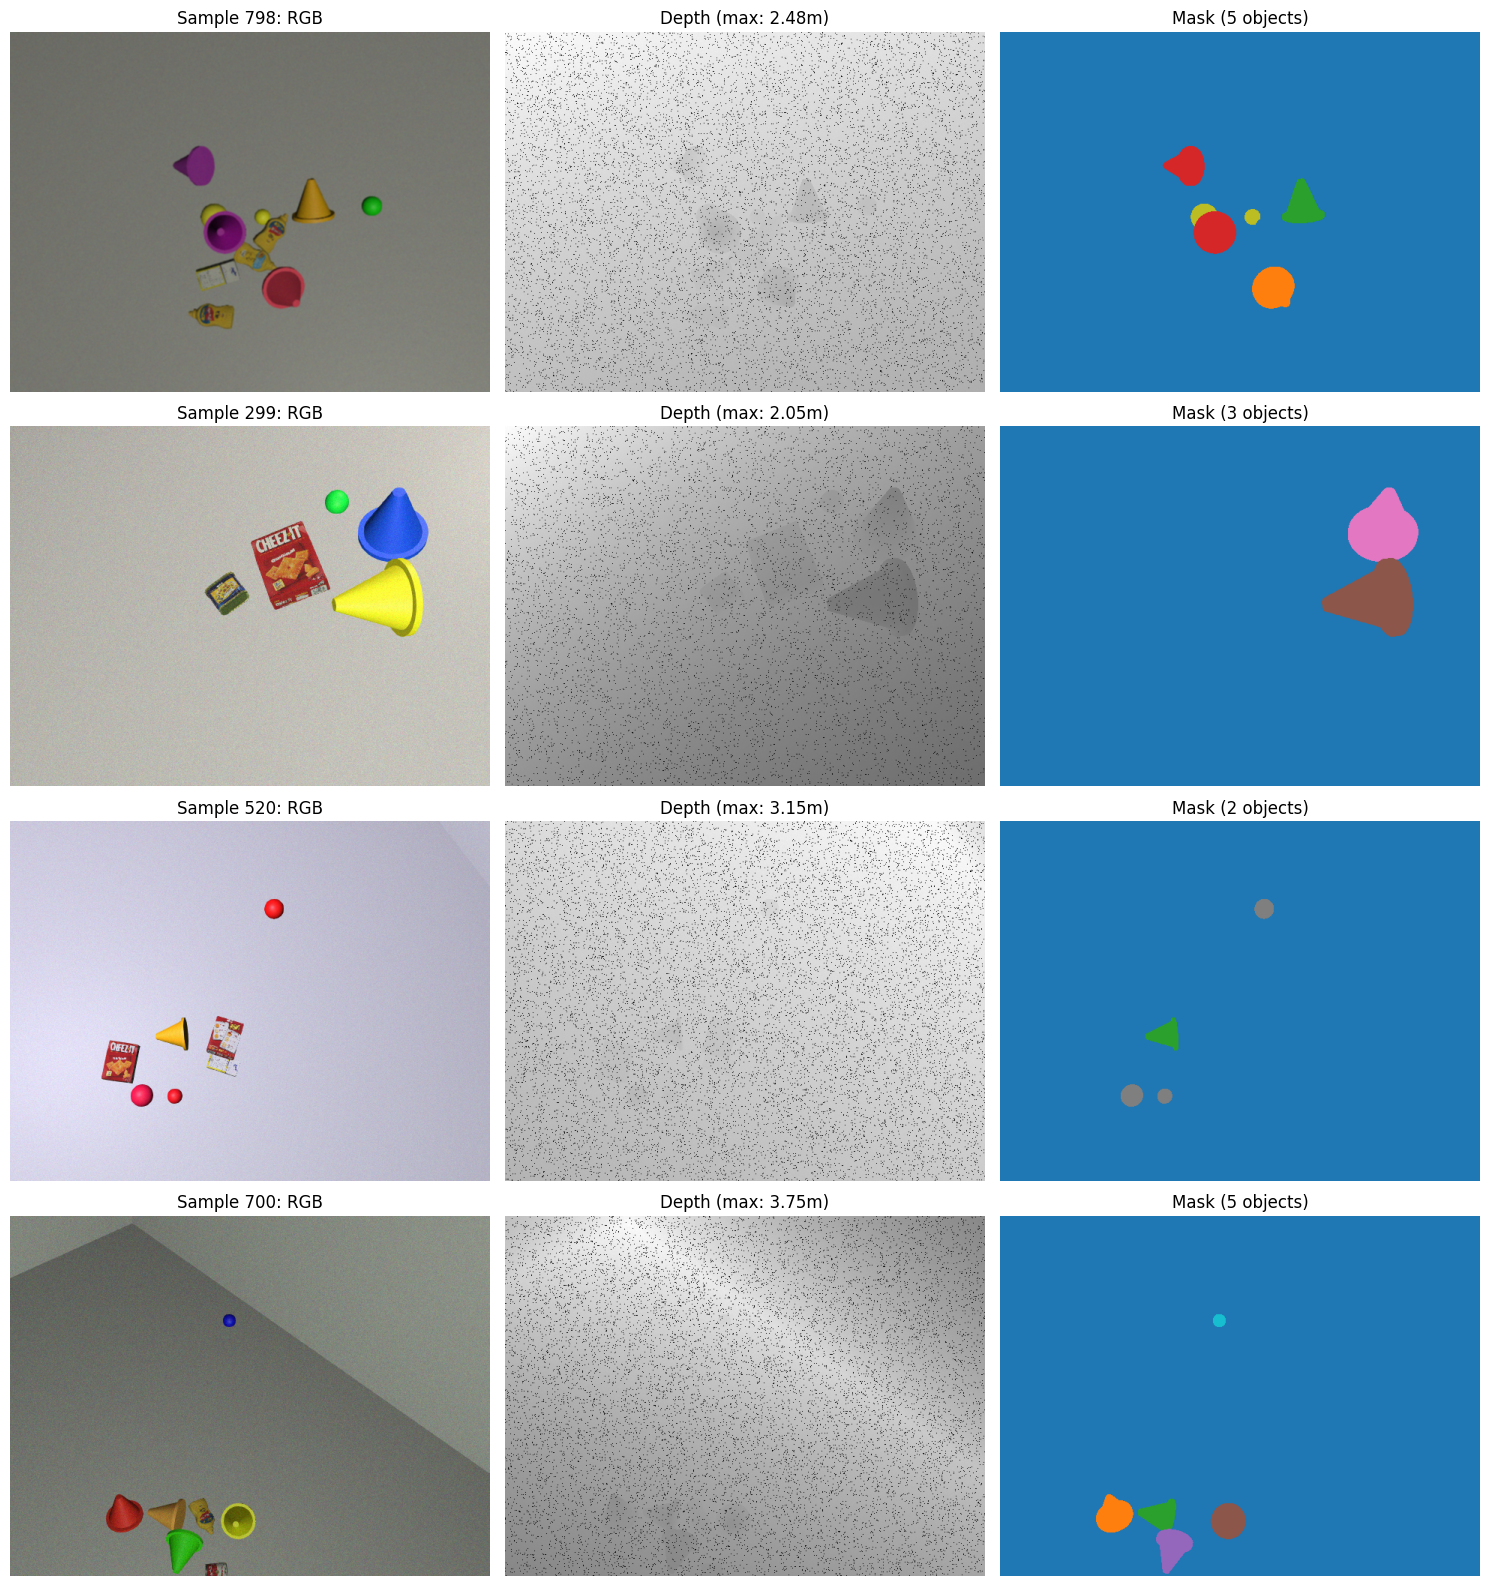

In [ ]:
# Visualize some random samples
if successful == 0:
    print("No images generated yet. Please run the dataset generation cell first.")
else:
    num_samples = min(4, successful)
    sample_indices = rng.choice(successful, num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample_idx in enumerate(sample_indices):
        filename = f"{sample_idx:06d}"
        
        # Load images
        rgb = np.array(Image.open(os.path.join(OUTPUT_DIR, "rgb", f"{filename}.png")))
        depth = np.array(Image.open(os.path.join(OUTPUT_DIR, "depth", f"{filename}.png")))
        mask = np.load(os.path.join(OUTPUT_DIR, "masks", f"{filename}.npy"))
        
        # Convert depth back to meters for visualization
        depth_m = depth.astype(np.float32) / 1000.0
        
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title(f"Sample {sample_idx}: RGB")
        axes[idx, 0].axis("off")
        
        axes[idx, 1].imshow(depth_m, cmap='gray')
        axes[idx, 1].set_title(f"Depth (max: {depth_m.max():.2f}m)")
        axes[idx, 1].axis("off")
        
        colorized_mask = colorize_labels(mask)
        if colorized_mask.dtype != np.uint8:
            colorized_mask = (colorized_mask * 255).astype(np.uint8) if colorized_mask.max() <= 1.0 else colorized_mask.astype(np.uint8)
        axes[idx, 2].imshow(colorized_mask)
        axes[idx, 2].set_title(f"Mask ({len(np.unique(mask))-1} objects)")
        axes[idx, 2].axis("off")
    
    plt.tight_layout()
    plt.show()


## Dataset Statistics


In [ ]:
# Analyze label distribution across dataset
if successful == 0:
    print("No images generated yet. Please run the dataset generation cell first.")
else:
    from tqdm import tqdm as tqdm_progress
    
    label_counts = {i: 0 for i in range(11)}  # 0 (background) + 10 classes
    pixel_counts = {i: 0 for i in range(11)}
    
    print("Analyzing dataset...")
    for i in tqdm_progress(range(successful)):
        filename = f"{i:06d}"
        mask = np.load(os.path.join(OUTPUT_DIR, "masks", f"{filename}.npy"))
        
        unique, counts = np.unique(mask, return_counts=True)
        for lbl, cnt in zip(unique, counts):
            if lbl in label_counts:
                label_counts[lbl] += 1
                pixel_counts[lbl] += cnt

print("\n" + "="*60)
print("Dataset Statistics")
print("="*60)
print(f"Total images: {successful}")
print(f"Image resolution: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")
print("\nLabel Distribution (number of images containing each class):")
print("-"*60)

for label_id in sorted(label_counts.keys()):
    count = label_counts[label_id]
    pixels = pixel_counts[label_id]
    
    if label_id == 0:
        name = "Background"
    else:
        # Find name
        name = None
        for n, l in CONE_LABELS.items():
            if l == label_id:
                name = f"{n.capitalize()} Cone"
                break
        if name is None:
            for n, l in BALL_LABELS.items():
                if l == label_id:
                    name = f"{n.capitalize()} Ball"
                    break
    
    if name:
        pct = (count / successful) * 100 if successful > 0 else 0
        print(f"  {label_id:2d} - {name:20s}: {count:4d} images ({pct:5.1f}%), {pixels:10d} pixels")

print("="*60)


Analyzing dataset...


100%|██████████| 1036/1036 [00:01<00:00, 731.74it/s]


Dataset Statistics
Total images: 1036
Image resolution: 640x480

Label Distribution (number of images containing each class):
------------------------------------------------------------
   0 - Background          : 1036 images (100.0%),  308990823 pixels
   1 - Red Cone            :  348 images ( 33.6%),    1305716 pixels
   2 - Orange Cone         :  352 images ( 34.0%),    1287139 pixels
   3 - Purple Cone         :  319 images ( 30.8%),    1071758 pixels
   4 - Green Cone          :  323 images ( 31.2%),    1140105 pixels
   5 - Yellow Cone         :  341 images ( 32.9%),    1167106 pixels
   6 - Blue Cone           :  343 images ( 33.1%),    1183606 pixels
   7 - Red Ball            :  398 images ( 38.4%),     572805 pixels
   8 - Yellow Ball         :  388 images ( 37.5%),     502603 pixels
   9 - Blue Ball           :  388 images ( 37.5%),     547303 pixels
  10 - Green Ball          :  379 images ( 36.6%),     490236 pixels


## PyTorch Dataset Example

Here's an example PyTorch Dataset class you can use for training:


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms

# class ConesBallsDataset(Dataset):
#     """
#     PyTorch Dataset for cone and ball segmentation with depth.
    
#     Returns:
#         rgb: (3, H, W) tensor, normalized to [0, 1]
#         depth: (1, H, W) tensor, in meters
#         mask: (H, W) tensor, integer labels 0-10
#     """
    
#     def __init__(self, data_dir, transform=None, depth_scale=1.0):
#         self.data_dir = data_dir
#         self.transform = transform
#         self.depth_scale = depth_scale
        
#         # Find all samples
#         self.samples = []
#         rgb_dir = os.path.join(data_dir, "rgb")
#         for filename in sorted(os.listdir(rgb_dir)):
#             if filename.endswith(".png"):
#                 sample_id = filename[:-4]  # Remove .png
#                 self.samples.append(sample_id)
    
#     def __len__(self):
#         return len(self.samples)
    
#     def __getitem__(self, idx):
#         sample_id = self.samples[idx]
        
#         # Load RGB
#         rgb_path = os.path.join(self.data_dir, "rgb", f"{sample_id}.png")
#         rgb = np.array(Image.open(rgb_path))
#         rgb = torch.from_numpy(rgb).permute(2, 0, 1).float() / 255.0  # (3, H, W)
        
#         # Load depth
#         depth_path = os.path.join(self.data_dir, "depth", f"{sample_id}.png")
#         depth = np.array(Image.open(depth_path)).astype(np.float32) / 1000.0  # Convert to meters
#         depth = torch.from_numpy(depth).unsqueeze(0) * self.depth_scale  # (1, H, W)
        
#         # Load mask
#         mask_path = os.path.join(self.data_dir, "masks", f"{sample_id}.npy")
#         mask = np.load(mask_path)
#         mask = torch.from_numpy(mask).long()  # (H, W)
        
#         # Apply transforms if specified
#         if self.transform:
#             # Stack rgb and depth for joint transformation
#             rgbd = torch.cat([rgb, depth], dim=0)  # (4, H, W)
#             rgbd = self.transform(rgbd)
#             rgb = rgbd[:3]
#             depth = rgbd[3:4]
        
#         return rgb, depth, mask


# # Example usage
# dataset = ConesBallsDataset(OUTPUT_DIR)
# print(f"\nDataset created with {len(dataset)} samples")

# # Test loading a sample
# rgb, depth, mask = dataset[0]
# print(f"Sample shapes: RGB={rgb.shape}, Depth={depth.shape}, Mask={mask.shape}")
# print(f"RGB range: [{rgb.min():.3f}, {rgb.max():.3f}]")
# print(f"Depth range: [{depth.min():.3f}, {depth.max():.3f}] meters")
# print(f"Mask unique labels: {torch.unique(mask).tolist()}")

# # Create DataLoader
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
# print(f"\nDataLoader created with batch_size=4")

# # Test batch
# for rgb_batch, depth_batch, mask_batch in dataloader:
#     print(f"Batch shapes: RGB={rgb_batch.shape}, Depth={depth_batch.shape}, Mask={mask_batch.shape}")
#     break
